# Removing Spikes from Raman Spectra with Anomaly Detection: Whitaker-Hayes algorithm in Python

__Abstract.__ In this notebook, I would like to comment on a new approach to remove spikes from Raman spectra, presented in the Chemometrics and Intelligent Laboratory Systems journal by D. Whitaker and K. Hayes¹. In their publication, the authors use a modified Z-scores outlier detection based algorithm to locate such spikes, when present, followed by a simple moving average to remove them. Instead of calculating the Z-scores of the spectrum intensity, they calculate the Z-scores of the once-differenced spectrum. They also provided the code for the algorithm implementation in R. Here, I present the implementation of the algorithm in Python and show how I applied it to a different data set.

This notebook was also published in Towards data science blog: https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22


### Spikes in Raman spectroscopy

Raman spectroscopy is a widely used analytical technique which provides structural and electronic information from molecules and solids. It is applicable at both laboratory and mass-production scales, and has applications in many different fields such as physics, chemistry, biology, medicine or industry.

A typical issue known in Raman spectroscopy is that Raman spectra are sometimes ‘contaminated’ by spikes. Spikes are positive, narrow bandwidth peaks present at random position on the spectrum. They originate when a high-energy cosmic ray impacts in the charge-couple device detector used to measure Raman spectra. These spikes are problematic as they might hinder subsequent analysis, particularly if multivariate data analysis is required. Therefore, one of the first steps in the treatment of Raman spectral data is the cleaning of spikes.

First, the Python packages that will be needed are loaded:

In [3]:
# Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Figure 1 shows the Raman spectrum of graphene. In the previous years, graphene has become a very popular material due to its remarkable physical properties, including superior electronic, thermal, optical and mechanical properties. Its characteristic Raman spectrum consists of several peaks as shown in the figure. From their shape and related intensity, a large amount of information such as doping, strain or grain boundaries can be learned. This spectrum is a clear example of a spectrum contaminated with a spike.

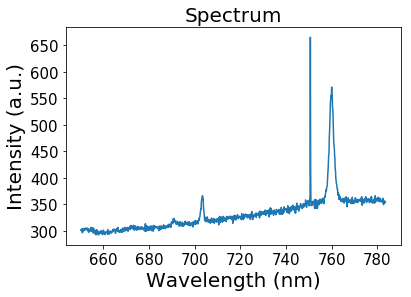

Figure 1. A spike was recorded while measuring the typical Raman spectrum of graphene (characterized by the G and 2D bands).


In [6]:
# load the data as df
df = pd.read_csv('C:/Users/Nico/Documents/anomaly detection/espectro2.txt', delimiter = '\t')

# Transform the data to a numpy array
wavelength = np.array(df.Wavelength)
intensity = np.array(df.Intensity)

# Plot the spectrum:
plt.plot(wavelength, intensity)
plt.title('Spectrum', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('Intensity (a.u.)', fontsize = 20)
plt.show()

print('Figure 1. A spike was recorded while measuring the typical Raman spectrum of graphene (characterized \
by the G and 2D bands).')

### Z-score based approach for spike detection in Raman spectra

Spikes intensities are normally above the intensities of other Raman peaks in the spectrum, therefore using a z-scores based method could be a good starting point. The z-scores tell how far a value is from the average in units of standard deviation. So, if the population mean and population standard deviation are known, the standard score of a raw score x(i) is calculated as:

z(i) = (x(i)-μ) / σ

where μ is the mean and σ is the standard deviation of the population x (x(i) represent the values of a single Raman spectrum). More in detail information on how to detect outliers using Z-score approaches can be found in reference [3].

Let’s calculate the z-scores for the points in our spectrum:

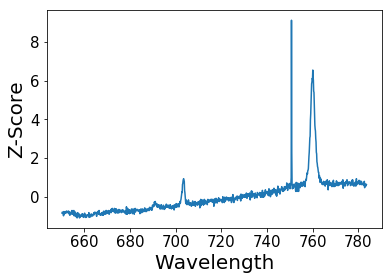

Figure 2. Z-scores of the spectrum plotted in figure 1.


In [10]:
# definition of a function to calculate the z score
def z_score(intensity):
    mean_int = np.mean(intensity)
    std_int = np.std(intensity)
    z_scores = (intensity - mean_int) / std_int
    return z_scores

# Selection of the threshold we will use
threshold = 3.5

# Calculation and plot of the z scores of the spectrum:
intensity_z_score = np.array(z_score(intensity))
plt.plot(wavelength, intensity_z_score)
#plt.title('Z-Score',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( 'Z-Score' ,fontsize = 20)
#plt.legend(loc = 'upper left' )
plt.show()
print('Figure 2. Z-scores of the spectrum plotted in figure 1.')

A threshold is then needed in order to tell whether a value is an outlier or not. A typical value for this threshold is 3.5, as proposed as guideline by the American Society of Quality control as the basis of an outlier-labeling rule², while the authors of the publication used 6. In order to apply a threshold to exclude spikes, the absolute value of the Z-score must be taken:

|z(i)| = |(x(i)-μ) / σ|

calculated as

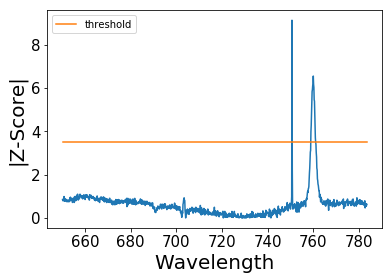

Figure 2b. Z-scores of the spectrum plotted in figure 1. The threshold still cuts the 2D Raman peak.


In [9]:
# Calculation and plot of the absolute value of the z scores

def z_score(intensity):
    mean_int = np.mean(intensity)
    std_int = np.std(intensity)
    z_scores = (intensity - mean_int) / std_int
    return z_scores

threshold = 3.5

intensity_z_score = np.array(abs(z_score(intensity)))

plt.plot(wavelength, intensity_z_score)
plt.plot(wavelength, threshold*np.ones(len(wavelength)), label = 'threshold') # Line showing the threshold
#plt.title('Z-Score',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( '|Z-Score|' ,fontsize = 20)
plt.legend(loc = 'upper left' )
plt.show()
print('Figure 2b. Z-scores of the spectrum plotted in figure 1. The threshold still cuts the 2D Raman peak.')

However, the z-score pretty much resembles the original spectrum and the threshold still cut off the main Raman peak. Let’s plot what was detected as spikes using a 3.5 threshold:

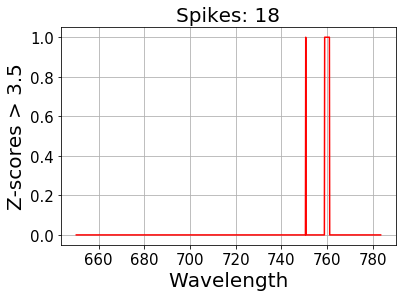

Figure 3.Using modified Z-Scores, 18 spectral point are above the threshold.


In [11]:
# Which points are considered spikes and which are not?

# 1 is assigned to spikes, 0 to non-spikes:
spikes = abs(np.array(z_score(intensity))) > threshold

# Let's look at it graphically:
plt.plot(wavelength, spikes, color = 'red')
plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( 'Z-scores > ' + str(threshold) ,fontsize = 20)
plt.show()
print('Figure 3.Using modified Z-Scores, 18 spectral point are above the threshold.')

Modified Z-score based approach for spike detection in Raman spectra

A second option would be making use of robust statistics and calculate the modified z-scores of the spectrum. This modified Z-score method uses the median (M) and median absolute deviation (MAD) rather than the mean and standard deviation:

z(i) = 0.6745 (x(i)-M) / MAD

where the MAD = median(|x-M|) and |…| represents the absolute value. Both the median and the MAD are robust measures of the central tendency and dispersion, respectively. The multiplier 0.6745 is the 0.75th quartile of the standard normal distribution, to which the MAD converges to⁴.

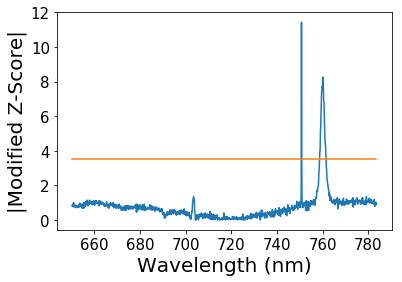

Figure 4. Modified Z-scores of the spectrum plotted in figure 1. The threshold still cuts the 2D Raman peak.


In [15]:
# definition of a function to calculate the modified z score. This time we calculate it with robust statistics:
def modified_z_score(intensity):
    median_int = np.median(intensity)
    mad_int = np.median([np.abs(intensity - median_int)])
    modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
    return modified_z_scores

# Calculation of the robust z scores of the spectrum and its plot:
intensity_modified_z_score = np.array(modified_z_score(intensity))
plt.plot(wavelength, abs(intensity_modified_z_score))
plt.plot(wavelength, threshold*np.ones(len(wavelength)), label = 'threshold')
#plt.title('Modified Z-Score')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)' ,fontsize = 20)
plt.ylabel('|Modified Z-Score|' ,fontsize = 20)
plt.show()
print('Figure 4. Modified Z-scores of the spectrum plotted in figure 1. \
The threshold still cuts the 2D Raman peak.')

The same issue can still be observed:

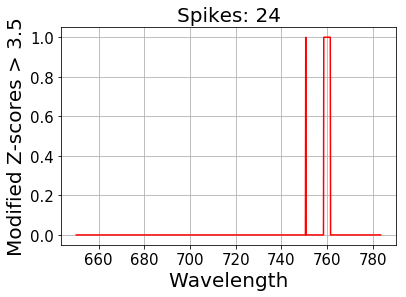

Figure 5. Using modified Z-Scores, 24 spectral points are above the threshold.


In [16]:
# Which points are considered spikes and which are not?
# 1 is assigned to spikes, 0 to non-spikes:
spikes = abs(np.array(modified_z_score(intensity))) > threshold

# Let's look at it graphically:
plt.plot(wavelength, spikes, color = 'red')
plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( 'Modified Z-scores > ' + str(threshold) ,fontsize = 20)
plt.show()
print('Figure 5. Using modified Z-Scores, 24 spectral points are above the threshold.')

The 2D Raman peak is still detected as spike, so a more sensitive approach is required.

### Whitaker and Hayes’ modified Z-score based approach for spike detection in Raman spectra

Whitaker and Hayes propose to make advantage of the high intensity and small width of spikes and therefore use the difference between consecutive spectrum points ∇x(i) = x(i)-x(i-1) to calculate the z-scores, where x(1), …, x(n) are the values of a single Raman spectrum recorded at equally spaced wavenumbers and i = 2, …, n. This step annihilates linear and slow moving curve linear trends, while sharp thin spikes will be preserved. Now,

z(i) = 0.6745 (∇x(i)-M) / MAD

So there is only an extra step included in which the difference between consecutive values are included.

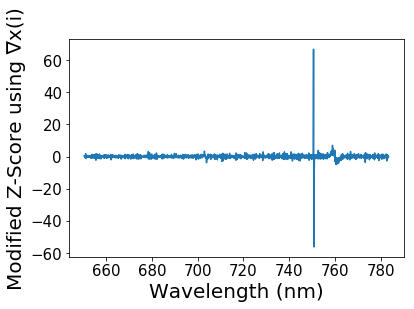

Figure 6. Modified Z-scores using ∇x(i) of the spectrum plotted in figure 1.


In [18]:
# Whitaker and Hayes approach consist of calculating the z score of the gradient of the spectrum

# First we calculated ∇x(i):
dist = 0
delta_intensity = [] 
for i in np.arange(len(intensity)-1):
    dist = intensity[i+1] - intensity[i]
    delta_intensity.append(dist)
delta_int = np.array(delta_intensity)

# Alternatively to the for loop one can use: 
# delta_int = np.diff(intensity)

# Calculation of the z scores of the gradient of the spectrum and its plot:
intensity_modified_z_score = np.array(modified_z_score(delta_int))
plt.plot(wavelength[1:], intensity_modified_z_score)
#plt.title('Modified Z-Score using ∇x(i)')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('Modified Z-Score using ∇x(i)', fontsize = 20)
plt.show()

print('Figure 6. Modified Z-scores using ∇x(i) of the spectrum plotted in figure 1.')

Again, in order to apply a threshold to exclude spikes, the absolute value of the modified Z-score must be taken:

|z(i)| =|0.6745 (∇x(i)-M) / MAD|

Resulting in

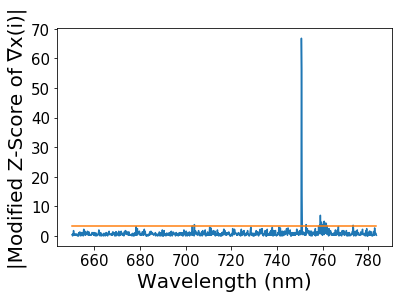

Figure 7. Abosolute value of the modified Z-scores of ∇x(i) of the spectrum plotted in figure 1.


In [20]:

# Threshold selection:
threshold = 3.5

# Plot of the absolute value of the z scores of the gradient of the spectrum:
intensity_modified_z_score = np.array(np.abs(modified_z_score(delta_int)))
plt.plot(wavelength[1:], intensity_modified_z_score)
plt.plot(wavelength[1:], threshold*np.ones(len(wavelength[1:])), label = 'threshold')
#plt.title('|Modified Z-Score of ∇x(i)|', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('|Modified Z-Score of ∇x(i)|', fontsize = 20)
plt.show()
print('Figure 7. Abosolute value of the modified Z-scores of ∇x(i) of the spectrum plotted in figure 1.')

And once more, the number of detected spikes can be calculated as

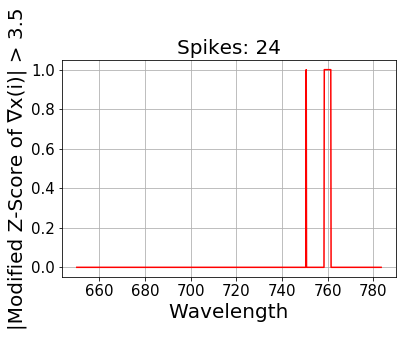

Figure 8. Using modified Z-Scores with ∇x(i), 17 spectral points are above the threshold = 3.5.


In [21]:
# Which points are considered spikes and which are not?
# 1 is assigned to spikes, 0 to non-spikes:
spikes = abs(np.array(modified_z_score(intensity))) > threshold
plt.plot(wavelength, spikes, color = 'red')
plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( '|Modified Z-Score of ∇x(i)| > ' + str(threshold) ,fontsize = 20)
plt.show()
print('Figure 8. Using modified Z-Scores with ∇x(i), 17 spectral points are above the threshold = 3.5.')

For the 3.5 recommended threshold many false spikes are assigned. However, the value scored by this approach is much higher in comparison with the Raman peaks than before.

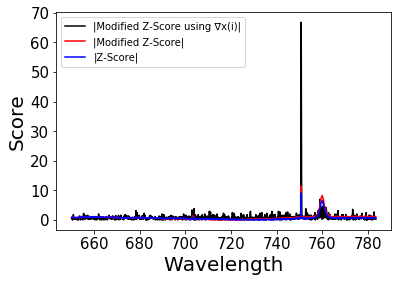

Figure 9. Comparison between the three different approaches.


In [23]:
# Graphical comparison of the three different approaches:

plt.plot(wavelength[1:], np.array(abs(modified_z_score(delta_int))), color='black', label = '|Modified Z-Score using ∇x(i)|')
plt.plot(wavelength, np.array(abs(modified_z_score(intensity))), label = '|Modified Z-Score|', color = 'red')
plt.plot(wavelength, np.array(abs(z_score(intensity))), label = '|Z-Score|', color = 'blue')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( 'Score' ,fontsize = 20)
plt.legend()
plt.show()
print('Figure 9. Comparison between the three different approaches.')

In general, the right threshold must be chosen depending on the data set. For this case, a threshold = 7 is already enough to obtain a clear selection.

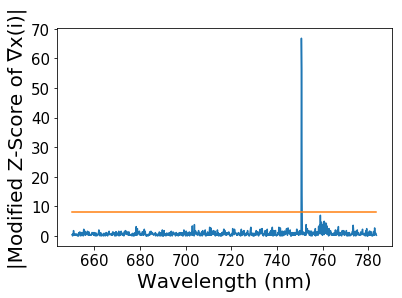

Figure 7. Abosolute value of the modified Z-scores of ∇x(i) of the spectrum plotted in figure 1.


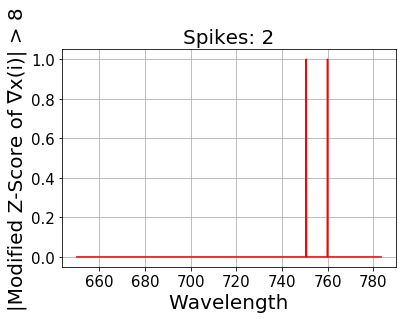

Figure 8. Using modified Z-Scores with ∇x(i), 17 spectral points are above the threshold = 3.5.


In [31]:

# Threshold selection:
threshold = 7

# Plot of the absolute value of the z scores of the gradient of the spectrum:
intensity_modified_z_score = np.array(np.abs(modified_z_score(delta_int)))
plt.plot(wavelength[1:], intensity_modified_z_score)
plt.plot(wavelength[1:], threshold*np.ones(len(wavelength[1:])), label = 'threshold')
#plt.title('|Modified Z-Score of ∇x(i)|', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('|Modified Z-Score of ∇x(i)|', fontsize = 20)
plt.show()
print('Figure 10. Absolute values of the modified Z-scores with ∇x(i) of the spectrum plotted in figure 1.')

# Which points are considered spikes and which are not?
# 1 is assigned to spikes, 0 to non-spikes:
spikes = abs(np.array(modified_z_score(intensity))) > threshold
plt.plot(wavelength, spikes, color = 'red')
plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( '|Modified Z-Score of ∇x(i)| > ' + str(threshold) ,fontsize = 20)
plt.show()
print('Figure 11. Using modified Z-Scores with ∇x(i), 3 spectral points are above the threshold = 7.')

### Fixing the Raman spectrum

Once the spikes are detected, the next step is to remove them and fix the spectra. For this, interpolated values are obtained at each candidate wavenumber by calculating the mean of its immediate neighbors (within a 2m+1 values window).

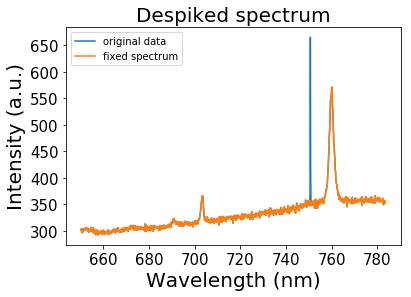

Figure 12. Original and despiked Raman spectrum using modified Z-Scores with ∇x(i) with the threshold = 


In [32]:
# Once the spike detection works, the spectrum can be fixed by calculating the average of the previous and the 
# next point to the spike

def fixer(y,m):
    threshold = 7 # binarization threshold. 
    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy() # So we don't overwrite y
    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            y_out[i] = np.mean(y[w2]) # and we average the value
 
    return y_out

# Does it work?
plt.plot(wavelength, intensity, label = 'original data')
plt.plot(wavelength, fixer(intensity,m=3), label = 'fixed spectrum')
plt.title('Despiked spectrum',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)' ,fontsize = 20)
plt.ylabel('Intensity (a.u.)' ,fontsize = 20)
plt.legend()
plt.show()

print('Figure 12. Original and despiked Raman spectrum using modified Z-Scores with ∇x(i) with the threshold = ')

So after calculation of the modified Z scores of ∇x, and thresholding by setting an appropiate threshold value, the spike is removed and smoothed by applying a moving average filter.

### 2nd example

This example show how even if the spike is much weaker in intensity is still detected and corrected, showing the strenght of this approach.

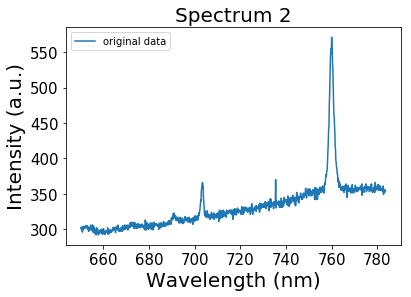

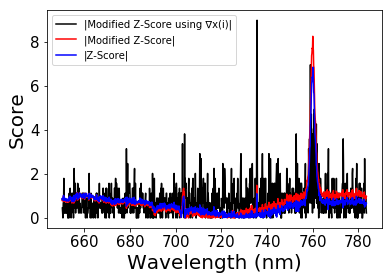

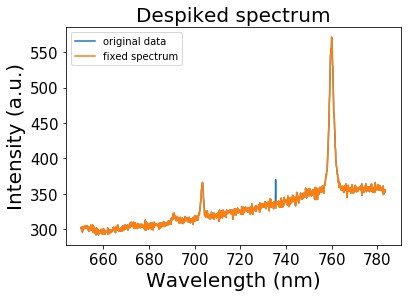

In [130]:
# Here there is a second example. In this case, the spike is much less intense than the Raman peaks.

spectrum2 = fixer(intensity,m=3)
spectrum2[650] = 370

# Plot of the second example spectrum:
plt.plot(wavelength, spectrum2, label = 'original data')
plt.title('Spectrum 2',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)' ,fontsize = 20)
plt.ylabel('Intensity (a.u.)' ,fontsize = 20)
plt.legend()
plt.show()

# Scores calculated with the three different approaches:
plt.plot(wavelength[1:], np.array(np.abs(modified_z_score(np.diff(spectrum2)))), color='black', label = '|Modified Z-Score using ∇x(i)|')
plt.plot(wavelength, np.array(abs(modified_z_score(spectrum2))), label = '|Modified Z-Score|', color = 'red')
plt.plot(wavelength, np.array(abs(z_score(spectrum2))), label = '|Z-Score|', color = 'blue')
#plt.title('Modified Z score',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)' ,fontsize = 20)
plt.ylabel('Score' ,fontsize = 20)
plt.legend()
plt.show()


# Fixing the spectrum:
plt.plot(wavelength, spectrum2, label = 'original data')
plt.plot(wavelength, fixer(spectrum2,m=3), label = 'fixed spectrum')
plt.title('Despiked spectrum',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)' ,fontsize = 20)
plt.ylabel('Intensity (a.u.)' ,fontsize = 20)
plt.legend()
plt.show()


### Summary
Whitaker-Hayes approach to detect spikes is based on applying Z-scores outlier detection algorithm to the derivative of the spectrum. A simple moving average is used to remove such spikes. Here I have presented the implementation of this algorithm in Jupyter notebook and shown how it works for detecting and removing a spike in a typical graphene spectrum. The approach was repeated for a second and weaker than the Raman signal spike, showing its strenght.

### Aknowledgements
I would like to thank [Jorge Luis Hita](https://medium.com/@jluishita) and [Ana Solaguren-Beascoa](https://medium.com/@ana.solagurenbeascoa) for taking the time to proofread this notes.



### References

[1] Whitaker, Darren A., and Kevin Hayes. “A simple algorithm for despiking Raman spectra.” Chemometrics and Intelligent Laboratory Systems 179 (2018): 82–84.

[2] Iglewicz, B., and D. Hoaglin. “The ASQC basic references in quality control: statistical techniques.” How to detect and handle outliers 16 (1993): 1–87.

[3] Colin Gorrie’s Data Story: Three ways to detect outliers. http://colingorrie.github.io/outlier-detection.html

[4] Joao Rodrigues. “Outliers make us go MAD: Univariate Outlier Detection”. Medium. https://medium.com/james-blogs/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7